In [2]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split

import pickle

c:\Users\Kyriakos\anaconda3\envs\nlp1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# set dir to the root of the project
os.chdir('..')
os.getcwd()

'c:\\Users\\Kyriakos\\Desktop\\MsC AI\\NLP\\NLP AirBNB Project\\AirBnB_score_prediction'

In [9]:
# read data 
df = pd.read_csv('dataset\listings_comments.csv')

In [4]:
# load comments embeddings
with open('embeddings\comments_embeddings.pkl', 'rb') as f:
    comments_embeddings = pickle.load(f)

In [5]:
comments_embeddings.shape

(6998, 384)

In [6]:
print(df.review_scores_rating.isna().sum())
# fill with mean
df.review_scores_rating.fillna(df.review_scores_rating.mean(), inplace=True)

print(df.review_scores_rating.isna().sum())

682
0


In [7]:
# import mse
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
metrics_df = pd.DataFrame()
mse = []
rmse = []
r2 = []
mae = []
model_names = []

# compute the mean squared error, RMSE and R2 score and MAE and show the results on a dataframe, append the results of each model
# in a list and then create a dataframe with the results
# compute the mean squared error, RMSE and R2 score and MAE and show the results on a dataframe, append the results of each model
# in a list and then create a dataframe with the results
def compute_metrics(model, X_test, y_test):

    if model.__class__.__name__ == 'MLPRegressor':
        y_pred = model(torch.tensor(X_test).float()).detach().numpy()
        y_pred = y_pred.reshape(-1)
        
    else:
        y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    model_name = model.__class__.__name__

    # create a temporary dataframe with the results for this model
    temp_df = pd.DataFrame({
        'model': [model_name],
        'mse': [mse],
        'rmse': [rmse],
        'r2': [r2],
        'mae': [mae]
    })

    # append the temporary dataframe to the metrics_df dataframe
    global metrics_df
    metrics_df = pd.concat([metrics_df, temp_df], ignore_index=True)
    
    print(metrics_df)


## Do some testing only with comments_embeddings

In [9]:
#  define X and y for training
X = comments_embeddings
y = df['review_scores_rating'].values

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    

In [62]:
# X.shape
# y.shape

In [33]:
from model.models.regressor import MLPRegressor, LossAccCallback

from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
# convert data to float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Define the PyTorch DataLoader for training and testing data
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=32)

# Define the MLPRegressor model
input_dim = X.shape[1] # get the size of the input dimension from the data
hidden_dim = 32
model = MLPRegressor(input_dim, hidden_dim)

# Define the PyTorch Lightning Trainer
trainer = pl.Trainer(callbacks=[LossAccCallback()],
                      max_epochs=10, accelerator="auto", devices="auto", strategy="auto")
# trainer = pl.Trainer(accelerator="auto", devices="auto", strategy="auto", max_epochs=10)

# Train the model
trainer.fit(model, train_loader)

# Test the model
trainer.test(model, test_loader)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: c:\Users\Kyriakos\Desktop\MsC AI\NLP\NLP AirBNB Project\AirBnB_score_prediction\lightning_logs

  | Name        | Type          | Params
----------------------------------------------
0 | autoencoder | _MLPRegressor | 25.7 K
----------------------------------------------
25.7 K    Trainable params
0         Non-trainable params
25.7 K    Total params
0.103     Total estimated model params size (MB)
c:\Users\Kyriakos\anaconda3\envs\nlp1\lib\site-packages\pytorch_lightning\trainer\call.py:54: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...



In [64]:
model.__class__.__name__

'MLPRegressor'

In [65]:
compute_metrics(model, X_test, y_test)

          model      mse      rmse        r2      mae
0  MLPRegressor  0.06555  0.256027 -0.211943  0.17336


In [10]:
# show loss curve with tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs/



### Visualize the results

In [66]:
# create a dataframe with the y and y_hat next to each other
y_hat = model(torch.tensor(X_test).float()).detach().numpy()
y_hat = y_hat.reshape(-1)
y_test = y_test.reshape(-1)
df = pd.DataFrame({'y': y_test, 'y_hat': y_hat})
df.head(10)

,y,y_hat
0,4.93000,4.730504
1,4.90000,4.809816
2,5.00000,4.699971
3,4.90000,4.838256
4,4.77000,3.815370
5,4.58000,4.951075
6,4.82000,4.967559
7,4.81804,4.799014
8,4.81804,4.799014
9,4.86000,4.977072


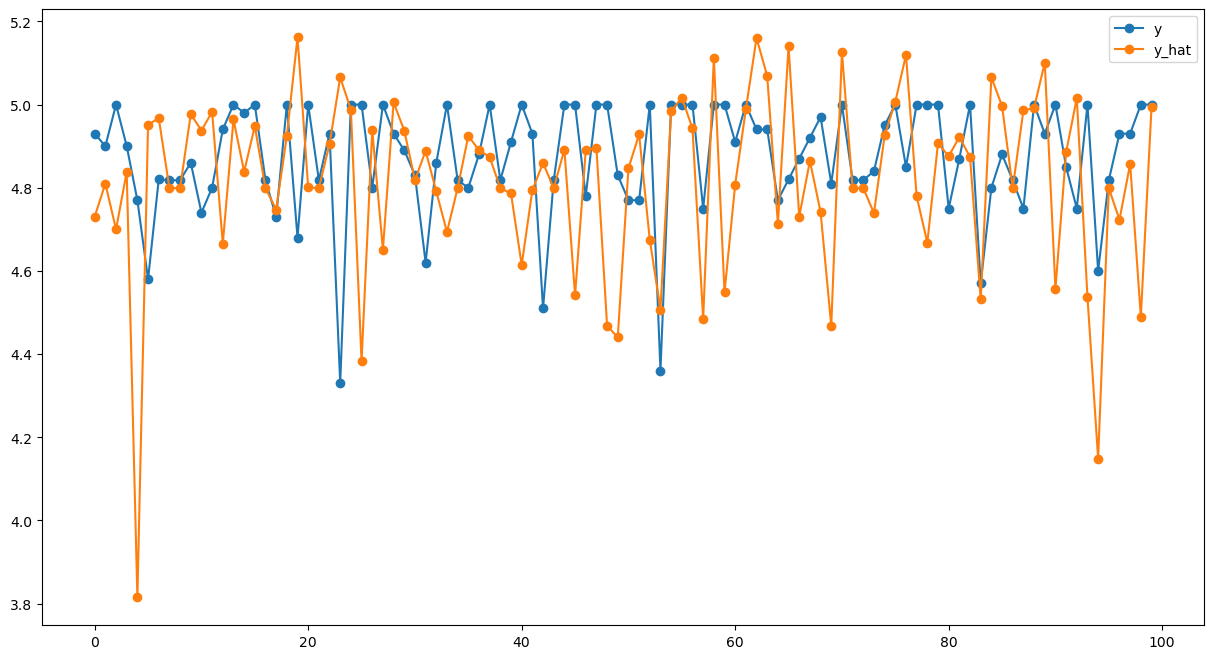

In [67]:
# plot the y and y_hat on two different graphs, plot  the first 100 values, plot in dots and lines
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.plot(df.y[:100], 'o-', label='y')
plt.plot(df.y_hat[:100], 'o-', label='y_hat')
plt.legend()
plt.show()
    




In [16]:
# We can see that the model have a good performance, comparing the y and y_hat values,in the dataframe
# and the loss curve with tensorboard. 
# Also observing the plot, we can see that the model is able to predict the values with a good accuracy.

### Random forest regressor


In [68]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# create the model
rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)

# train the model
rf.fit(X_train, y_train)

# predict
y_hat = rf.predict(X_test)

# compute the mean squared error
print(mean_squared_error(y_test, y_hat))



0.08461974253730825


In [69]:
compute_metrics(rf, X_test, y_test)

                   model      mse      rmse        r2       mae
0           MLPRegressor  0.06555  0.256027 -0.211943  0.173360
1  RandomForestRegressor  0.08462  0.290895 -0.564529  0.161129


### let's try a different model, a gradient boosting regressor


In [70]:

from sklearn.ensemble import GradientBoostingRegressor

# create the model
gb = GradientBoostingRegressor(n_estimators=20, max_depth=10, random_state=42)

# train the model
gb.fit(X_train, y_train)

# predict
y_hat = gb.predict(X_test)

#  compute metrics
compute_metrics(gb, X_test, y_test)

                       model       mse      rmse        r2       mae
0               MLPRegressor  0.065550  0.256027 -0.211943  0.173360
1      RandomForestRegressor  0.084620  0.290895 -0.564529  0.161129
2  GradientBoostingRegressor  0.053813  0.231976  0.005056  0.144138


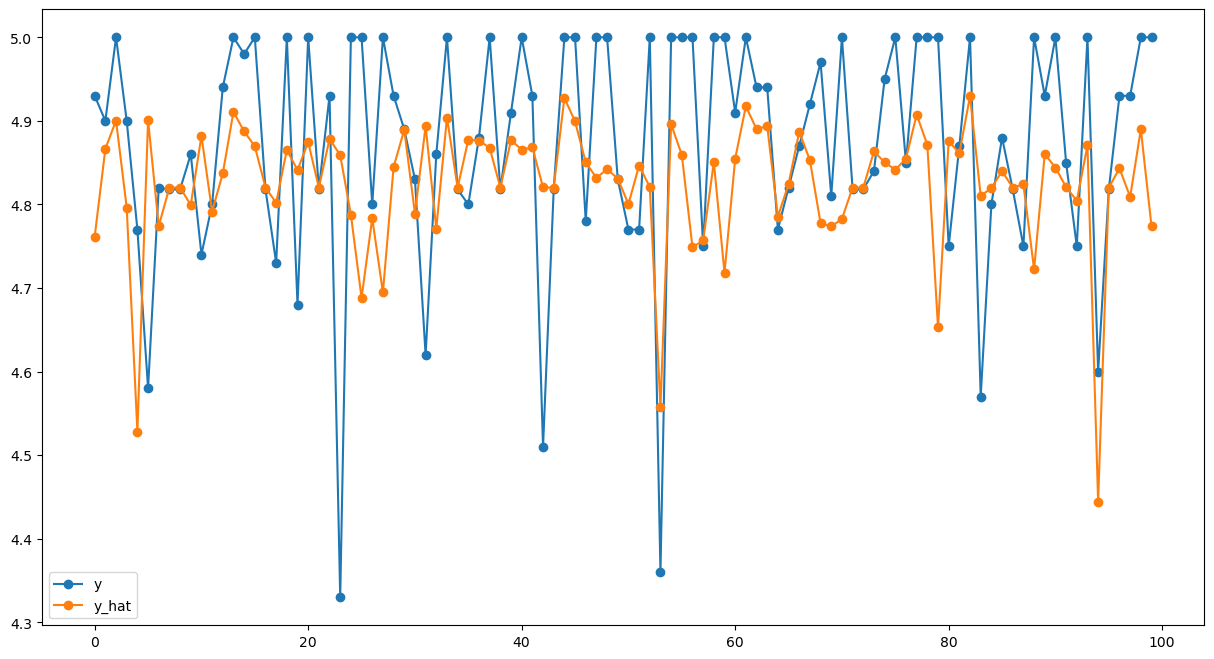

In [72]:
# plot accuracy
plt.figure(figsize=(15, 8))
plt.plot(y_test[:100], 'o-', label='y')
plt.plot(y_hat[:100], 'o-', label='y_hat')
plt.legend()
plt.show()

### LGBMRegressor

In [73]:
from lightgbm import LGBMRegressor


# create the model
lgbm = LGBMRegressor(n_estimators=100, max_depth=10, random_state=42)

# train the model
lgbm.fit(X_train, y_train)

# predict
y_hat = lgbm.predict(X_test)

# compute the loss metrics
compute_metrics(lgbm, X_test, y_test)



                       model       mse      rmse        r2       mae
0               MLPRegressor  0.065550  0.256027 -0.211943  0.173360
1      RandomForestRegressor  0.084620  0.290895 -0.564529  0.161129
2  GradientBoostingRegressor  0.053813  0.231976  0.005056  0.144138
3              LGBMRegressor  0.050202  0.224057  0.071826  0.142878


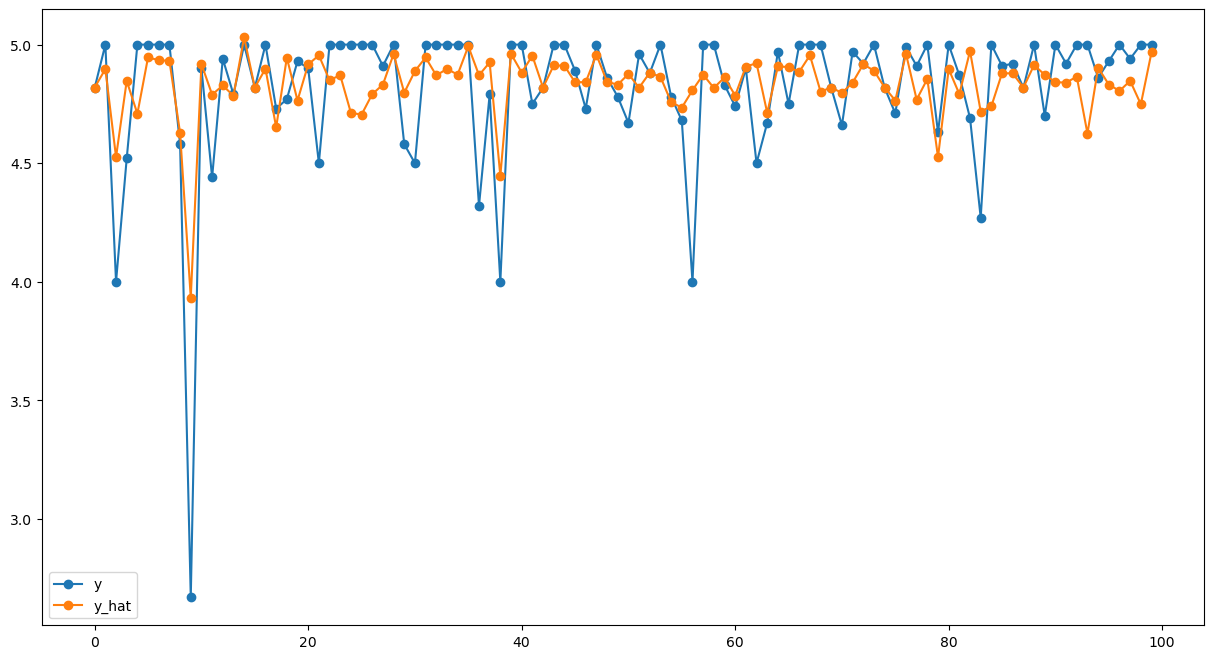

In [74]:
# plot the y and y_hat on two different graphs, plot  the first 100 values, plot in dots and lines
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.plot(y_test[100:200], 'o-', label='y')
plt.plot(y_hat[100:200], 'o-', label='y_hat')
plt.legend()


In [75]:
# we can see that the LGBMRegressor model have the best performance, because
#  it is optimised for high dimensional data, and it is faster than the other models.
# Also can handle non linear relationships between the features and the target variable.
# moreover has a built-in feature importance analysis which can help identify which features are most importan

In [9]:
os.getcwd()
# cd back
os.chdir('../..')

## Merge description and comments embeddings


In [8]:

with open('embeddings\description_embeddings.pkl', 'rb') as f:
    description_embeddings = pickle.load(f)

# with open('embeddings\comments_embeddings.pkl', 'rb') as f:
#     comments_embeddings = pickle.load(f)

# merge the two embeddings
X = np.concatenate((description_embeddings, comments_embeddings), axis=1)

# define y
y = df['review_scores_rating'].values

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Predict with the LGBMRegressor model

# create the model
lgbm = LGBMRegressor(n_estimators=200, max_depth=10, random_state=42)

# train the model
lgbm.fit(X_train, y_train)

# predict
y_hat = lgbm.predict(X_test)

# compute the loss metrics
compute_metrics(lgbm, X_test, y_test)



           model       mse      rmse        r2       mae
0  LGBMRegressor  0.049304  0.222044  0.088427  0.141926


In [23]:
from model.models.regressor import MLPRegressor, LossAccCallback

from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl

# merge the two embeddings
X = np.concatenate((description_embeddings, comments_embeddings), axis=1)

# define y
y = df['review_scores_rating'].values

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# convert data to float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Define the PyTorch DataLoader for training and testing data
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=32)

# Define the MLPRegressor model
input_dim = X.shape[1] # get the size of the input dimension from the data
hidden_dim = 32
model = MLPRegressor(input_dim, hidden_dim)

# Define the PyTorch Lightning Trainer
trainer = pl.Trainer(callbacks=[LossAccCallback()],
                      max_epochs=10, accelerator="auto", devices="auto", strategy="auto")
# trainer = pl.Trainer(accelerator="auto", devices="auto", strategy="auto", max_epochs=10)

# Train the model
trainer.fit(model, train_loader)

# Test the model
trainer.test(model, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type          | Params
----------------------------------------------
0 | autoencoder | _MLPRegressor | 25.7 K
----------------------------------------------
25.7 K    Trainable params
0         Non-trainable params
25.7 K    Total params
0.103     Total estimated model params size (MB)
c:\Users\Kyriakos\anaconda3\envs\nlp1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 175/175 [00:01<00:00, 92.03it/s, v_num=2] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 175/175 [00:01<00:00, 91.55it/s, v_num=2]


c:\Users\Kyriakos\anaconda3\envs\nlp1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 44/44 [00:00<00:00, 230.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.08422276377677917
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.08422276377677917}]

In [24]:
compute_metrics(model, X_test, y_test)

           model       mse      rmse        r2       mae
0  LGBMRegressor  0.049304  0.222044  0.088427  0.141926
1   MLPRegressor  0.084223  0.290212 -0.557190  0.211230


## Load all the embeddings

In [12]:
with open('embeddings\listing_processed_data.pkl', 'rb') as f:
    df = pickle.load(f)

df.shape

(6809, 1186)

In [7]:
with open('embeddings\listing_processed_data.pkl', 'rb') as f:
    df = pickle.load(f)


# extract only embedding columns picking the word "embeddings" in the column name
embedding_columns = [col for col in df.columns if 'embeddings' in col]
embedding_columns

# create a new dataframe with only the embedding columns
df_embeddings = df[embedding_columns]





In [11]:
X = df_embeddings.values
X.shape
# y = df['review_scores_rating'].values

# # split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Use LGBMRegressor model

# # create the model
# lgbm = LGBMRegressor(n_estimators=200, max_depth=10, random_state=42)

# # train the model
# lgbm.fit(X_train, y_train)

# # predict
# y_hat = lgbm.predict(X_test)



(6809, 1152)